In [1]:
#importing all the libraries and neccessary packages 
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import glob

import nibabel as nib
import cv2
import imageio
from tqdm.notebook import tqdm


from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from matplotlib.patches import Rectangle

from ipywidgets import *
from PIL import Image
import fastai; fastai.__version__

'2.7.11'

In [2]:
#A function for Uploading all of the images and storing them in a list from the dataset that we downloaded 
def read_files():
    file_list = []
    
    # loading the location and putting all the files in the array
    # first one that we are iterating is the masked value or the optimum result 
    for dirname, _, filenames in os.walk(r"/Users/sumanlata/Documents/Image Analysis/Project /archive/segmentation"):
        for filename in filenames:
            file_list.append((dirname,filename)) 
    
    #the sample images over which we iterate 
    for dirname, _, filenames in os.walk(r"/Users/sumanlata/Documents/Image Analysis/Project /archive/volume_pt1"):
        for filename in filenames:
            file_list.append((dirname,filename)) 
        
    for dirname, _, filenames in os.walk(r"/Users/sumanlata/Documents/Image Analysis/Project /archive/volume_pt2"):
        for filename in filenames:
            file_list.append((dirname,filename)) 

    for dirname, _, filenames in os.walk(r"/Users/sumanlata/Documents/Image Analysis/Project /archive/volume_pt3"):
        for filename in filenames:
            file_list.append((dirname,filename)) 
        
    for dirname, _, filenames in os.walk(r"/Users/sumanlata/Documents/Image Analysis/Project /archive/volume_pt4"):
        for filename in filenames:
            file_list.append((dirname,filename)) 
        
    for dirname, _, filenames in os.walk(r"/Users/sumanlata/Documents/Image Analysis/Project /archive/volume_pt5"):
        for filename in filenames:
            file_list.append((dirname,filename)) 
    print(len(file_list) )     
    
    #Sorting files 
    df_files = pd.DataFrame(file_list, columns =['dirname', 'filename']) 
    df_files.sort_values(by=['filename'], ascending=True)
    df_files["mask_dirname"] = "" ; df_files["mask_filename"] = ""        
    
    #Naming files and saving the masking value too 
    for i in range(131):
        ct = f"volume-{i}.nii"
        mask = f"segmentation-{i}.nii"
    
        df_files.loc[df_files['filename'] == ct, 'mask_filename'] = mask
        df_files.loc[df_files['filename'] == ct, 'mask_dirname'] = "/Users/sumanlata/Documents/Image Analysis/Project /archive/segmentations"
        
    df_files = df_files[df_files.mask_filename != ''].sort_values(by=['filename']).reset_index(drop=True) 
    #print the length of array of files and return the same array 
    print(len(df_files))
    return df_files  

In [3]:
#reading the files
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)  

In [4]:
def Hist_equal(a):
    #Histogram Equalization (image enhancement)(option 1)
    img = sample_ct[:,:,a].astype(np.uint8)
    hist1 = cv2.calcHist([img],[0],None,[256],[0,256])
    img_HEQ = cv2.equalizeHist(img)
    hist2 = cv2.calcHist([img_HEQ],[0],None,[256],[0,256])

    plt.subplot(221),plt.imshow(img, cmap = "gray");
    plt.subplot(222),plt.plot(hist1);
    plt.subplot(223),plt.imshow(img_HEQ, cmap = "gray");
    plt.subplot(224),plt.plot(hist2);
    plt.show()
    #Contrast Limited adaptive histogram equalization (image enhancement)(Option 2)
    #this is additional enhancement that takes the histeq results and further adjusts the histogram

    clahe=cv2.createCLAHE(clipLimit=40) #sets threshold value for contrast limiting, default of 40
    img_clahe=clahe.apply(img_HEQ) #applies clahe to the histeq image

    plt.subplot(211),plt.imshow(img_HEQ, cmap = "gray"); #plots original and clahe in a subplot 
    plt.subplot(212),plt.imshow(img_clahe, cmap = "gray");
    plt.show()

    #Inverse Gaussian (image enhancement)(option 3)
    # This is seperate from the histeq and clahe

    img_norm = img / np.max(img)
    img_IG = 1 - np.exp(-img_norm**2/220)
    img_IG = img_IG*255

    # hist3 = cv2.calcHist([img_IG],[0],None,[256],[0,256]) #calculates histogram of the IG adjusted image
    plt.subplot(221),plt.imshow(img, cmap = "gray"); #show og image
    # plt.subplot(222),plt.plot(hist1); #show og hist
    plt.subplot(223),plt.imshow(img_IG, cmap = "gray"); #show IG image
    # plt.subplot(224),plt.plot(hist3); #show IG hist
    
    #plotting to see how image looks
    plt.imshow(sample_mask[:,:,a], cmap= "gray"); 
    return img , img_HEQ , clahe , img_IG 

In [70]:
def liver_detection(img , a , b , x, y , i , alpha , beta):
    #a = initial one is r // moves the circle height or x-axis of the circle 
    #b = the second value is r // moves the circle height or x-axis of the circle
    #x = initial value in c // moves the width or x-axis of the  circle 
    #y = second value in c  // moves the width or x-axis of the  circle
    # i = is the slice number 
    # alpha and beta are the values used in the active contour 
    
    s = np.linspace(0, 2*np.pi, 2000)
    r = a+ b*np.sin(s) 
    c = x + y*np.cos(s) 


    #calling the snakes algorithm 
    init = np.array([r, c]).T
    snake = active_contour(gaussian(img, 3, preserve_range=False),
                           init, alpha=alpha, beta=beta, gamma=0.001)
    
    #plotting the result of liver identification
    fig, ax = plt.subplots(figsize=(7 , 7))   
    ax.imshow(img, cmap=plt.cm.gray)
    x ,y = img.shape
    #covering all the background with all balck for easy identification 
    ax.add_patch(Rectangle((0, 0), x, y , facecolor = "black") )
    
    #red ouline circle - the circle with which we initialize
    ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
    
    #blue filled between the liver 
    ax.fill_between(snake[:, 1], snake[:, 0], '-b', lw=3  )
    
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])

    #saving the image and displaying it 
    plt.savefig("/Users/sumanlata/Documents/Image Analysis/Project /Photos/result"+str(i)+".png")#location of storage 
    plt.show()

51
51
(512, 512, 466)
<class 'numpy.ndarray'>


/var/folders/2r/ssg2txy913j87nxnjsnl0qxw0000gn/T/ipykernel_1350/1736705024.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221),plt.imshow(img, cmap = "gray");


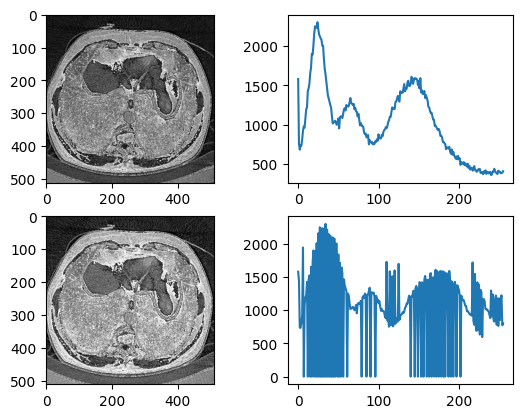

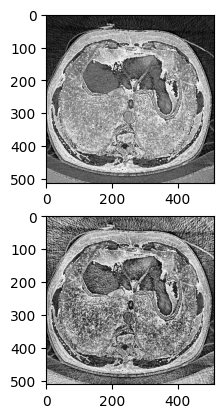

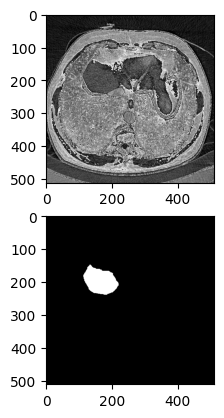

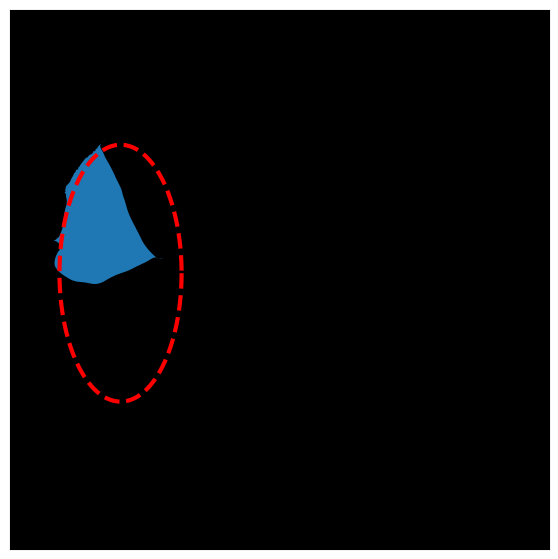

In [109]:
#MAIN 
#file where we execute the main code 
# Read sample
df_files = read_files() 
#print(df_files)

sample = 3
#reading the sample file and working the same file 
sample_ct   = read_nii(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
print(sample_ct.shape)

#the optimum file with which we will compare 
sample_mask  = read_nii(df_files.loc[sample,'mask_dirname']+"/"+df_files.loc[sample,'mask_filename'])
#print(sample_ct.shape) 
#print(sample_mask.shape)
#print(df_files.loc[sample,'dirname']+"/"+df_files.loc[sample,'filename'])
#plotting sample image to see how it looks
#plt.imshow((sample_ct[:,:,410]).astype(np.float32), cmap = 'gray')

#calling a slice at any value A (which is between 280 and 430 ) 

a = 430
plt.imshow((sample_mask[:,:,a]).astype(np.int64)  )
plt.savefig("/Users/sumanlata/Documents/Image Analysis/Project /Photos/ideal-rgb"+str(a)+".png" , transparent=True)
a = sample_ct[:,:,].astype(np.uint8)

print(type(a[0][0]))
img , img_HEQ , clahe , img_IG = Hist_equal(430)



liver_detection(img_HEQ ,250 , 122, 105, 58 ,350 , 0.3 , 0.1  )


(512, 512) (512, 512)
0.011096954345703125
97.5


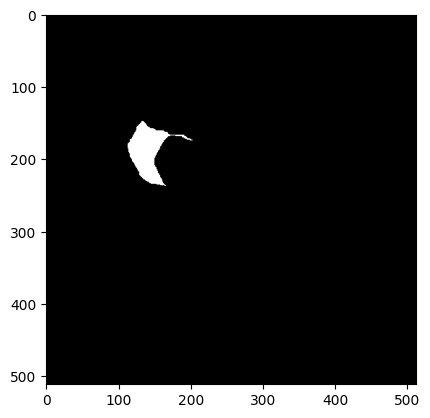

In [75]:
import cv2 as cv 
import PIL 
from PIL import Image
import imageio
#now Comparing our result with the Ideal result 
i=430
#firstly we are calling the ideal output and the output we generated 
img1  = sample_mask[: , : , 430]
img2 = cv.imread('/Users/sumanlata/Documents/Image Analysis/Project /Photos/result430.png' , 0)


#resizing the our generated output as it has different dimensions and type then the original output 
new_image = cv.resize(img2 , (512 , 512) , Image.Resampling.LANCZOS)
print(img1.shape , new_image.shape)

img1 = img1.astype(np.uint8)
#Calculating the MSE
#MSE
h,w = img1.shape
diff = cv.subtract(img1 , new_image)
err = np.sum(diff**2)
mse = err/(float(h*w))
#printing out the result and showing the difference image 
print(mse)
#plt.savefig("/Users/sumanlata/Documents/Image Analysis/Project /Photos/difference"+str(i)+".png")
plt.imshow(diff, cmap = "gray")
plt.savefig("/Users/sumanlata/Documents/Image Analysis/Project /Photos/difference"+str(i)+".png")

#Calculating the DICE
#DICE
intersect = np.sum(img1*new_image)
fsum = np.sum(img1)
ssum = np.sum(new_image)
dice = (2 * intersect ) / (fsum + ssum)
dice = np.mean(dice)
dice = round(dice, 3)
print((1-dice)*100)

In [76]:
###So what our code does is :- 
'''
1. we call the read_files function it makes a array of all the dataset of files and also a includes entries of the 
ideal output(with which we are comparing) , then sorting these files and stores the nii files according to location
2.We take a sample 3 and call 2 functions , in the first function we get the 'sample CT' scan this is provided and in
the second function we get the "Sample mask" with we are gonna compare at the end 
3. Now we call the 'Hist_equal()' after which we get 4 different types of images original Image , Histogram Equalized 
Image , Contrast Limited adaptive histogram equalized image and Inverse Gaussian image
4.Then we will send the Histogram equalized image to the our Liver detection function which uses the snakes Algorithm 
, we give in the the initial coordinates for the circle , which shrinks or narrows down to the size of liver 
5. Then we send the output Liver outline and compare it to the ideal output and calculate the Mean sqaure error (MSE) 
and Dice similarity coefficient 
'''


'\n1. we call the read_files function it makes a array of all the dataset of files and also a includes entries of the \nideal output(with which we are comparing) , then sorting these files and stores the nii files according to location\n2.We take a sample 3 and call 2 functions , in the first function we get the \'sample CT\' scan this is provided and in\nthe second function we get the "Sample mask" with we are gonna compare at the end \n3. Now we call the \'Hist_equal()\' after which we get 4 different types of images original Image , Histogram Equalized \nImage , Contrast Limited adaptive histogram equalized image and Inverse Gaussian image\n4.Then we will send the Histogram equalized image to the our Liver detection function which uses the snakes Algorithm \n, we give in the the initial coordinates for the circle , which shrinks or narrows down to the size of liver \n5. Then we send the output Liver outline and compare it to the ideal output and calculate the Mean sqaure error (MSE)

In [ ]:
#Calculating the volume of liver in the results 
import cv2 as cv
import PIL 
from PIL import Image
import numpy as np 

#iterating over all the saved results files 
for i in range(280 , 431 , 10):
    img1 = cv.imread('/Users/sumanlata/Documents/Image Analysis/Project /Photos/result'+str(i)+'.png' , 0 )

    #counting the nonzero values in the array if image
    b = 2.5
    n_black_1 = cv.countNonZero(img1)
    
    n_white_pix = np.sum(img1 == 255)
    n_black_pix = np.sum(img1 == 0)
    h , w = img1.shape
    total = h*w
    print("total" , total)
    remaining = total - n_white_pix - n_black_pix 
    print("total difference :- " , total - n_white_pix - n_black_pix)
    print(n_black_1-  n_white_pix)
    # cv.imshow("image" , img )
    cv.imshow("Original Image" , img1)


    print("remaining :-"  , remaining)
    print("Total Area :- " , remaining * 0.2645*2.15  )
    cv.waitKey(0)

In [ ]:
#Calculating the volume of liver in the ground truth
import cv2 as cv
import PIL 
from PIL import Image
import numpy as np 


for i in range(280 , 431 , 10):
    image = Image.open('/Users/sumanlata/Documents/Image Analysis/Project /Photos/idea'+str(i)+'.png' )

    area =0 

    array = { (0,0,0,255) }

    for pixel in image.getdata():
    if(pixel[0] != 0 and pixel[1] != 0 and pixel[2] != 0  and pixel[0] != 255 and pixel[1] != 255 and pixel[2] != 255  ):
            if(pixel != (68,1,84,255)):
                area +=1
                array.add(pixel)



    print(array)
    print (area)
    print("Total Area :- " , area * 0.2645*2.15*b  )       

    cv.waitKey(0)